In [87]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt 

import datetime
import calendar
import matplotlib.dates as mdates

## This notebook contains data cleaning as a result of finding row values with discrepancies based on logic.  To view those examples, please view my prep notebook. [Hotel Booking Prep by Joseph Burton] (https://www.kaggle.com/josephburton06/hotel-booking-prep)

# Hypotheses:

## H1. The City hotel will have more check-ins than the Resort hotel.  The thought is that a Resort will see extended stay customers.  Is a KPI for count of check-ins per month/week/year the best KPI?

## H2. Long lead times will increase the possibility of a customer cancelling.

## H3. With some visits listed as \$0 ADR, these reservations will see fewer cancellations.

## H4. Summer months will see higher traffic.

## H5. Customers with non-refundable deposits will cancel/no-show less.

# Data Cleaning/Prep/Feature Engineering Pipeline:

In [2]:
def load_data():
    #Read data from locally stored CSV.  The CSV file is from Kaggle.
    return pd.read_csv('hotel_bookings.csv')

In [3]:
def create_date_month(df):
    #Create a month numeric column to be used to create a DateTime
    d = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,\
         'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}
    
    #Create new column month with int value
    df['month'] = df.arrival_date_month.map(d)
    
    return df

In [4]:
def create_datetime(df):
    #Rename arrival_date_year/month columns to be able to concatenate 
    #them all for a DateTime column
    df.rename(columns={'arrival_date_year': 'year', \
                       'arrival_date_day_of_month': 'day'}, inplace=True)

    #Create datetime value
    df['arrival_date'] = pd.to_datetime(df[['year', 'month' , 'day']])
    
    return df

In [5]:
def create_day_of_week(df):
    #Values assigned will be 0-6, with Monday = 0 and Sunday = 6.  
    #With this logic, the code in the next cell can be used to 
    #create a weekend/weekday column.
    df['arrival_day_of_week'] = [x.dayofweek for x in df.arrival_date]
    
    return df

In [6]:
def is_weekend(df):
    #Fridays are 5's and Saturdays are 6's.  Where 5 or 6, put a 1 to indicate the arrival
    #date was on a weekend and put a 0 to indicate it wasn't a weekend.
    df['arrival_day_is_weekend'] = np.where(df['arrival_day_of_week'] >= 5, 1, 0)
    
    return df

In [7]:
def cancel_rate(df):
    df['cancel_rate'] = df['previous_cancellations'] / \
    (df['previous_cancellations'] + df['previous_bookings_not_canceled'])

    df['cancel_rate'].fillna(0, inplace=True)
    
    return df

In [8]:
def total_guests(df):
    #Replacing 0's with 1's in the adult column on the assumption 
    #that an adult must check in and use the room.
    df['adults'].replace({0:1}, inplace=True) 
    
    df['children'].fillna(0, inplace=True)
    
    df['total_guests'] = df['adults'] + df['children'] + df['babies']
    
    return df

In [9]:
def total_nights_stay(df):
    df['total_nights_stay'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']
    
    #Find the rows where total_nights_stay = 0, and the arrival day is not a weekend.
    #Place a 1 in the stays_in_week_nights column.
    df.loc[((df['total_nights_stay'] == 0) & (df['arrival_day_is_weekend'] == 0)\
              ), 'stays_in_week_nights' ] = 1
    
    #Find the rows where total_nights_stay = 0, and the arrival day is a weekend.
    #Place a 1 in the stays_in_weekend_nights column
    df.loc[((df['total_nights_stay'] == 0) & (df['arrival_day_is_weekend'] == 1)\
              ), 'stays_in_weekend_nights' ] = 1
    
    df['total_nights_stay'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']
    
    return df

In [10]:
def total_dollar(df):
    df['total_dollar'] = df['total_nights_stay'] * df['adr']
    
    return df

In [11]:
def total_previous_bookings(df):
    df['total_previous_bookings'] = \
        df['previous_cancellations'] + df['previous_bookings_not_canceled']
    
    return df

In [12]:
def change_repeat_customer(df):
    #Where the customer is listed as a repeated guest, but has no previous bookings
    #they will be changed to 0.
    df['is_repeated_guest'] = np.where(df['total_previous_bookings'] == 0\
                                , 0, df['is_repeated_guest'])
    
    #Where the customer is listed as a first time guest, but has previous bookings
    #they will be changed to 1.
    df['is_repeated_guest'] = np.where(df['total_previous_bookings'] > 0\
                                , 1, df['is_repeated_guest'])
    
    return df

In [13]:
def no_negative_adr(df):
    #Change min ADR to 0.  $0 a night is feasible based on a rewards program.
    #I don't like the thought of a customer receving money for their stay.  
    #I think that's a data issue.
    df['adr'] = df['adr'].clip(lower=0.0)
    
    return df

In [14]:
def handle_nulls_subject_to_change(df):
    df['agent'].fillna(0.0, inplace=True)
    df['country'].fillna('Unknown', inplace=True)
    
    #In the original data, 'company' as 94.3% nulls.
    #If this is somehow corrected, a new approach 
    #may be needed.
    df.drop(columns=['company'], inplace=True)
    
    return df

In [15]:
def lead_time_bins(df):
    #Create two columns, bins for the lead time the reservation was made

    #The lead_time_bin will have values with ranges like '10 - 20'
    lead_time_bin = []
    lead_time_bin_order_by = []

    for index,row in df.iterrows():
        #Lead time of 0, will remain 0
        if row['lead_time'] == 0:
            lead_time_bin.append(str(row['lead_time']))
            lead_time_bin_order_by.append(0)
        
        #Lead times between 1 and 100 will be binned into 10's (1-10, 11-20, etc.)
        elif row['lead_time'] <= 100:
            max_bin = int(np.ceil(row['lead_time'] / 10) * 10)
            min_bin = int(max_bin - 9)
            lead_time_bin_range = '{} - {}'.format(min_bin, max_bin)
            lead_time_bin.append(lead_time_bin_range)
            lead_time_bin_order_by.append(max_bin)
        
        #To limit the number of bins, after 100 days lead time,
        #bins will be grouped into 50 day ranges.
        elif 100 < row['lead_time'] < 1000:
            number = row['lead_time'] / 100
            number_int = int(number)
            number_dec = '.' + str(number - number_int).split('.')[1]

            if float(number_dec) < .5:
                min_bin = (number_int * 100) + 1
                max_bin = (number_int * 100) + 50
                lead_time_bin_range = '{} - {}'.format(min_bin, max_bin)
                lead_time_bin.append(lead_time_bin_range)
                lead_time_bin_order_by.append(max_bin)

            elif float(number_dec) >= .5:
                min_bin = (number_int * 100) + 51
                max_bin = (number_int + 1) * 100
                lead_time_bin_range = '{} - {}'.format(min_bin, max_bin)
                lead_time_bin.append(lead_time_bin_range)
                lead_time_bin_order_by.append(max_bin)

        else:
            lead_time_bin.append('?')
            lead_time_bin_order_by.append(99999)

    df['lead_time_bin'] = lead_time_bin
    df['lead_time_bin_order_by'] = lead_time_bin_order_by
    
    return df

In [16]:
def create_charge_nocharge(df):
    #Make a more readable columns to indicate if a customer paid
    #for the room or did not pay
    df['charge_no_charge'] = \
        df['adr'].apply(lambda x: 'No Charge' if x == 0 else 'Charge')
    
    return df

In [17]:
df=(
    load_data()
    .pipe(create_date_month)
    .pipe(create_datetime)
    .pipe(create_day_of_week)
    .pipe(is_weekend)
    .pipe(cancel_rate)
    .pipe(total_guests)
    .pipe(total_nights_stay)
    .pipe(total_dollar)
    .pipe(total_previous_bookings)
    .pipe(change_repeat_customer)
    .pipe(no_negative_adr)
    .pipe(handle_nulls_subject_to_change)
    .pipe(lead_time_bins)
    .pipe(create_charge_nocharge)
)
df.head().T

,0,1,2,3,4
hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel
is_canceled,0,0,0,0,0
lead_time,342,737,7,13,14
year,2015,2015,2015,2015,2015
arrival_date_month,July,July,July,July,July
arrival_date_week_number,27,27,27,27,27
day,1,1,1,1,1
stays_in_weekend_nights,0,0,0,0,0
stays_in_week_nights,1,1,1,1,2
adults,2,2,1,1,2


# Creating df's for EDA:
### Creating df's for H1 and H4:

In [18]:
#Create a new df to house only actual visits
all_check_ins = df[['hotel', 'arrival_date']][df['reservation_status'] == 'Check-Out']

#Create a column of 1's to use later to aggregate and sum
all_check_ins['check_in_count'] = 1

In [19]:
#Create a year-month column
#This df is still at transaction/reservation level
all_check_ins['year_month'] = \
    all_check_ins['arrival_date'].dt.strftime('%Y-%m')

all_check_ins.head(3)

,hotel,arrival_date,check_in_count,year_month
0,Resort Hotel,2015-07-01,1,2015-07
1,Resort Hotel,2015-07-01,1,2015-07
2,Resort Hotel,2015-07-01,1,2015-07


In [20]:
#Aggregate to day level.  There's a value that will be used
#from this table that we will apply later, so we will not go
#straight to year-month.
all_check_ins_by_day = \
    all_check_ins[['hotel', 'year_month', 'arrival_date', 'check_in_count']]\
        .groupby(['hotel', 'year_month', 'arrival_date'], as_index=False).sum()

all_check_ins_by_day.head(3)

,hotel,year_month,arrival_date,check_in_count
0,City Hotel,2015-07,2015-07-01,65
1,City Hotel,2015-07,2015-07-02,1
2,City Hotel,2015-07,2015-07-03,10


In [21]:
#A new df to aggregate to year-month
#With results spanning 26 consecutive months, 
#this is a good solution for visualizations.
all_check_ins_by_year_month = \
    all_check_ins_by_day[['hotel', 'year_month', 'check_in_count']]\
        .groupby(['hotel', 'year_month',], as_index=False).sum()

all_check_ins_by_year_month.head(3)

,hotel,year_month,check_in_count
0,City Hotel,2015-07,459
1,City Hotel,2015-08,1248
2,City Hotel,2015-09,1986


In [22]:
#Creating a new dataframe to house rows where the customer is listed
#as 'Check-Out', indicating that they did occupy a room during their stay.
arrival_dates_customers_stayed = \
    df[['hotel', 'arrival_date', 'total_nights_stay', 'adr', 'total_guests']]\
    [df['reservation_status'] == 'Check-Out'].reset_index()

#We will use the index as a customer/reservation number since each row is a single
#record of some customer's stay.  We don't have something to indicate
#that a set of transactions belong to a single customer.
arrival_dates_customers_stayed.rename(columns={'index':'cust_num'}, inplace=True)

display(arrival_dates_customers_stayed.head())

display(arrival_dates_customers_stayed.tail())

,cust_num,hotel,arrival_date,total_nights_stay,adr,total_guests
0,0,Resort Hotel,2015-07-01,1,0.0,2.0
1,1,Resort Hotel,2015-07-01,1,0.0,2.0
2,2,Resort Hotel,2015-07-01,1,75.0,1.0
3,3,Resort Hotel,2015-07-01,1,75.0,1.0
4,4,Resort Hotel,2015-07-01,2,98.0,2.0


,cust_num,hotel,arrival_date,total_nights_stay,adr,total_guests
75161,119385,City Hotel,2017-08-30,7,96.14,2.0
75162,119386,City Hotel,2017-08-31,7,225.43,3.0
75163,119387,City Hotel,2017-08-31,7,157.71,2.0
75164,119388,City Hotel,2017-08-31,7,104.40,2.0
75165,119389,City Hotel,2017-08-29,9,151.20,2.0


In [23]:
#Empty dataframe to house new data that will contain a row
#for each night a guest stayed during their reservation
all_dates = pd.DataFrame(columns=['cust_num','room_filled_dates'])

#In this code, we are taking each observation from the hotel check-in 
#data and creating a row for each night that the guest stayed in the hotel.
#We are using a a timedelta function and taking a day off of that.
#We are doing this so we do not count the check-out date as
#a night that a room was occupied.  This approach is being used
#because simply applying all nights stayed to the month containing
#the arrival date could lead to nights stayed applied to the incorrect
#month based on the fact that some guests will check-in during one month,
#stay a few nights, and check-out the next month.

for index, row in arrival_dates_customers_stayed.iterrows():
    #This creates a date range for a customer's stay where 
    date_range = pd.DataFrame(pd.date_range(row['arrival_date'],
                                row['arrival_date'] + \
                                datetime.timedelta(days=row['total_nights_stay'] - 1)), \
                                  columns=['room_filled_dates'])

    date_range.insert(loc=0, column='cust_num', value=row['cust_num'])
    
    all_dates = pd.concat([all_dates, date_range])

In [24]:
#Create a column that has only 1's in it.  These can be used
#when grouping by time intervals by summing to get a count of
#the number of rooms occupied for the night/month/etc.
all_dates['room_occupied'] = 1
display(all_dates.head())

,cust_num,room_filled_dates,room_occupied
0,0,2015-07-01,1
0,1,2015-07-01,1
0,2,2015-07-01,1
0,3,2015-07-01,1
0,4,2015-07-01,1


In [25]:
#cust_num is an object in all_dates, changing to int to help the join coming up
all_dates['cust_num']= all_dates['cust_num'].astype(str).astype(int)

In [26]:
#all_dates df now has a row for each night a customer stays.  We will left
#join to bring in values like 'adr'.
all_dates = all_dates.merge\
        (arrival_dates_customers_stayed[['cust_num', 'hotel', 'total_nights_stay', 'adr', 'total_guests']]\
        ,how='left' ,left_on='cust_num', right_on='cust_num', validate='many_to_one')

In [27]:
#These are the dates for check-ins.  We will adjust the date range
#used in room occupancy with the thought that rooms may be occupied
#by guests that arrived prior to 2015-07-01.  Additionally, guests
#arriving near the end of our date range will show as occupying a
#a room, but new guests will not be visible.
print(df.arrival_date.min())
print(df.arrival_date.max())

2015-07-01 00:00:00
2017-08-31 00:00:00


In [28]:
mask = (all_dates['room_filled_dates'] > '2015-07-07') \
    & (all_dates['room_filled_dates'] <= '2017-08-31')

In [29]:
all_dates = all_dates.loc[mask]

#Verifying date range has changed:
print(all_dates.room_filled_dates.min())
print(all_dates.room_filled_dates.max())

2015-07-08 00:00:00
2017-08-31 00:00:00


In [30]:
#To verify, below are the first 5 rows for customers that show as 'Check-Out'
#in the original dataframe, which we will compare to the new all_dates dataframe.
#The index below is what is used as 'cust_num' in all_dates.  Notice that the first 
#4 rows (0-3 index) show a single night stay, while the fifth (index 4), shows 2 nights.
display(df[['arrival_date', 'total_nights_stay', 'adr', 'hotel']]\
    [df['reservation_status'] == 'Check-Out'].head())

display(df[['arrival_date', 'total_nights_stay', 'adr', 'hotel']]\
    [df['reservation_status'] == 'Check-Out'].tail(2))

,arrival_date,total_nights_stay,adr,hotel
0,2015-07-01,1,0.0,Resort Hotel
1,2015-07-01,1,0.0,Resort Hotel
2,2015-07-01,1,75.0,Resort Hotel
3,2015-07-01,1,75.0,Resort Hotel
4,2015-07-01,2,98.0,Resort Hotel


,arrival_date,total_nights_stay,adr,hotel
119388,2017-08-31,7,104.4,City Hotel
119389,2017-08-29,9,151.2,City Hotel


In [31]:
#As noted above, cust_num 4 now has 2 rows
#Additionally, in the tail, we see the customer that stayed 9 nights.
display(all_dates.head(10))
display(all_dates.tail(10))

,cust_num,room_filled_dates,room_occupied,hotel,total_nights_stay,adr,total_guests
107,30,2015-07-08,1,Resort Hotel,14,62.00,1.0
108,30,2015-07-09,1,Resort Hotel,14,62.00,1.0
109,30,2015-07-10,1,Resort Hotel,14,62.00,1.0
110,30,2015-07-11,1,Resort Hotel,14,62.00,1.0
111,30,2015-07-12,1,Resort Hotel,14,62.00,1.0
112,30,2015-07-13,1,Resort Hotel,14,62.00,1.0
113,30,2015-07-14,1,Resort Hotel,14,62.00,1.0
121,31,2015-07-08,1,Resort Hotel,15,63.86,2.0
122,31,2015-07-09,1,Resort Hotel,15,63.86,2.0
123,31,2015-07-10,1,Resort Hotel,15,63.86,2.0


,cust_num,room_filled_dates,room_occupied,hotel,total_nights_stay,adr,total_guests
255676,119384,2017-08-30,1,City Hotel,7,96.14,2.0
255677,119384,2017-08-31,1,City Hotel,7,96.14,2.0
255683,119385,2017-08-30,1,City Hotel,7,96.14,2.0
255684,119385,2017-08-31,1,City Hotel,7,96.14,2.0
255690,119386,2017-08-31,1,City Hotel,7,225.43,3.0
255697,119387,2017-08-31,1,City Hotel,7,157.71,2.0
255704,119388,2017-08-31,1,City Hotel,7,104.40,2.0
255711,119389,2017-08-29,1,City Hotel,9,151.20,2.0
255712,119389,2017-08-30,1,City Hotel,9,151.20,2.0
255713,119389,2017-08-31,1,City Hotel,9,151.20,2.0


In [161]:
all_dates.loc[(all_dates.total_nights_stay == 5) & (all_dates.room_filled_dates > '2015-07-15')].head()

,cust_num,room_filled_dates,room_occupied,hotel,total_nights_stay,adr,total_guests
1392,342,2015-07-16,1,Resort Hotel,5,123.0,2.0
1397,344,2015-07-16,1,Resort Hotel,5,196.0,4.0
1402,345,2015-07-16,1,Resort Hotel,5,149.4,2.0
1460,366,2015-07-16,1,Resort Hotel,5,120.0,2.0
1461,366,2015-07-17,1,Resort Hotel,5,120.0,2.0


In [162]:
all_dates.loc[all_dates.cust_num == 345]

,cust_num,room_filled_dates,room_occupied,hotel,total_nights_stay,adr,total_guests
1398,345,2015-07-12,1,Resort Hotel,5,149.4,2.0
1399,345,2015-07-13,1,Resort Hotel,5,149.4,2.0
1400,345,2015-07-14,1,Resort Hotel,5,149.4,2.0
1401,345,2015-07-15,1,Resort Hotel,5,149.4,2.0
1402,345,2015-07-16,1,Resort Hotel,5,149.4,2.0


In [169]:
pd.DataFrame(df[['hotel', 'is_canceled', 'arrival_date', 'total_nights_stay', 'adr', 'total_guests']].iloc[345]).T

,hotel,is_canceled,arrival_date,total_nights_stay,adr,total_guests
345,Resort Hotel,0,2015-07-12 00:00:00,5,149.4,2


In [171]:
df[['hotel', 'total_nights_stay']].loc[df.is_canceled == 0]\
    .groupby(['hotel']).mean().reset_index()

,hotel,total_nights_stay
0,City Hotel,2.930280
1,Resort Hotel,4.155747


In [32]:
all_hotel_visits_by_day = \
    all_dates[['hotel', 'room_filled_dates', 'room_occupied', 'adr', 'total_guests']]\
    .groupby(['hotel', 'room_filled_dates'], as_index=False).sum()

In [33]:
#Creating a year-month combo to use for visualizations
all_hotel_visits_by_day['year_month'] = \
    all_hotel_visits_by_day['room_filled_dates'].dt.strftime('%Y-%m')

In [34]:
#We are working with 2 different hotels, without details like the 
#amount of rooms available.  We are going to use our best estimate
#for the number of available rooms.  We will aggregate the count
#of rooms occupied for each night.  The day with the most rooms
#being used will be used as our proxy for the max amount of rooms
#in each hotel.

resort_max_occ = all_hotel_visits_by_day['room_occupied']\
    [all_hotel_visits_by_day['hotel'] == 'Resort Hotel'].max()

city_max_occ = all_hotel_visits_by_day['room_occupied']\
    [all_hotel_visits_by_day['hotel'] == 'City Hotel'].max()

print('Max Resort Occ: {} -- Max City Occ: {}'.format(resort_max_occ, city_max_occ))

Max Resort Occ: 187 -- Max City Occ: 250


In [35]:
#We will now apply each max amount to each row by hotel.

max_occ_vals = []

for index,row in all_hotel_visits_by_day.iterrows():
    if row['hotel'] == 'City Hotel':
        max_occ_vals.append(city_max_occ)
    else:
        max_occ_vals.append(resort_max_occ)
        
all_hotel_visits_by_day['max_daily_occ'] = max_occ_vals
    
all_hotel_visits_by_day.head(2)

,hotel,room_filled_dates,room_occupied,adr,total_guests,year_month,max_daily_occ
0,City Hotel,2015-07-08,27,1624.72,54.0,2015-07,250
1,City Hotel,2015-07-09,27,1607.54,53.0,2015-07,250


In [36]:
#Grouping the sum of rooms occupied by year-month
all_hotel_visits_by_month = \
    all_hotel_visits_by_day[['hotel', 'year_month', 'adr', 'room_occupied','max_daily_occ', 'total_guests']]\
    .groupby(['hotel', 'year_month'], as_index=False).sum()
display(all_hotel_visits_by_month.head(3))
display(all_hotel_visits_by_month.tail(3))

,hotel,year_month,adr,room_occupied,max_daily_occ,total_guests
0,City Hotel,2015-07,58342.15,841,6000,1590.0
1,City Hotel,2015-08,275450.09,3443,7750,6732.0
2,City Hotel,2015-09,592053.75,5570,7500,9703.0


,hotel,year_month,adr,room_occupied,max_daily_occ,total_guests
49,Resort Hotel,2017-06,590282.86,5247,5610,10834.0
50,Resort Hotel,2017-07,914044.05,5544,5797,12751.0
51,Resort Hotel,2017-08,1104725.11,5608,5797,13336.0


In [37]:
#You might have figured out where we're headed by now...
all_hotel_visits_by_month['occ_rate'] = \
    all_hotel_visits_by_month['room_occupied'] / all_hotel_visits_by_month['max_daily_occ']

all_hotel_visits_by_month.head(2)

,hotel,year_month,adr,room_occupied,max_daily_occ,total_guests,occ_rate
0,City Hotel,2015-07,58342.15,841,6000,1590.0,0.140167
1,City Hotel,2015-08,275450.09,3443,7750,6732.0,0.444258


# H1 Viz

## Let's take a look at check-ins only. This is like buying a whole CD to get the single track that you like

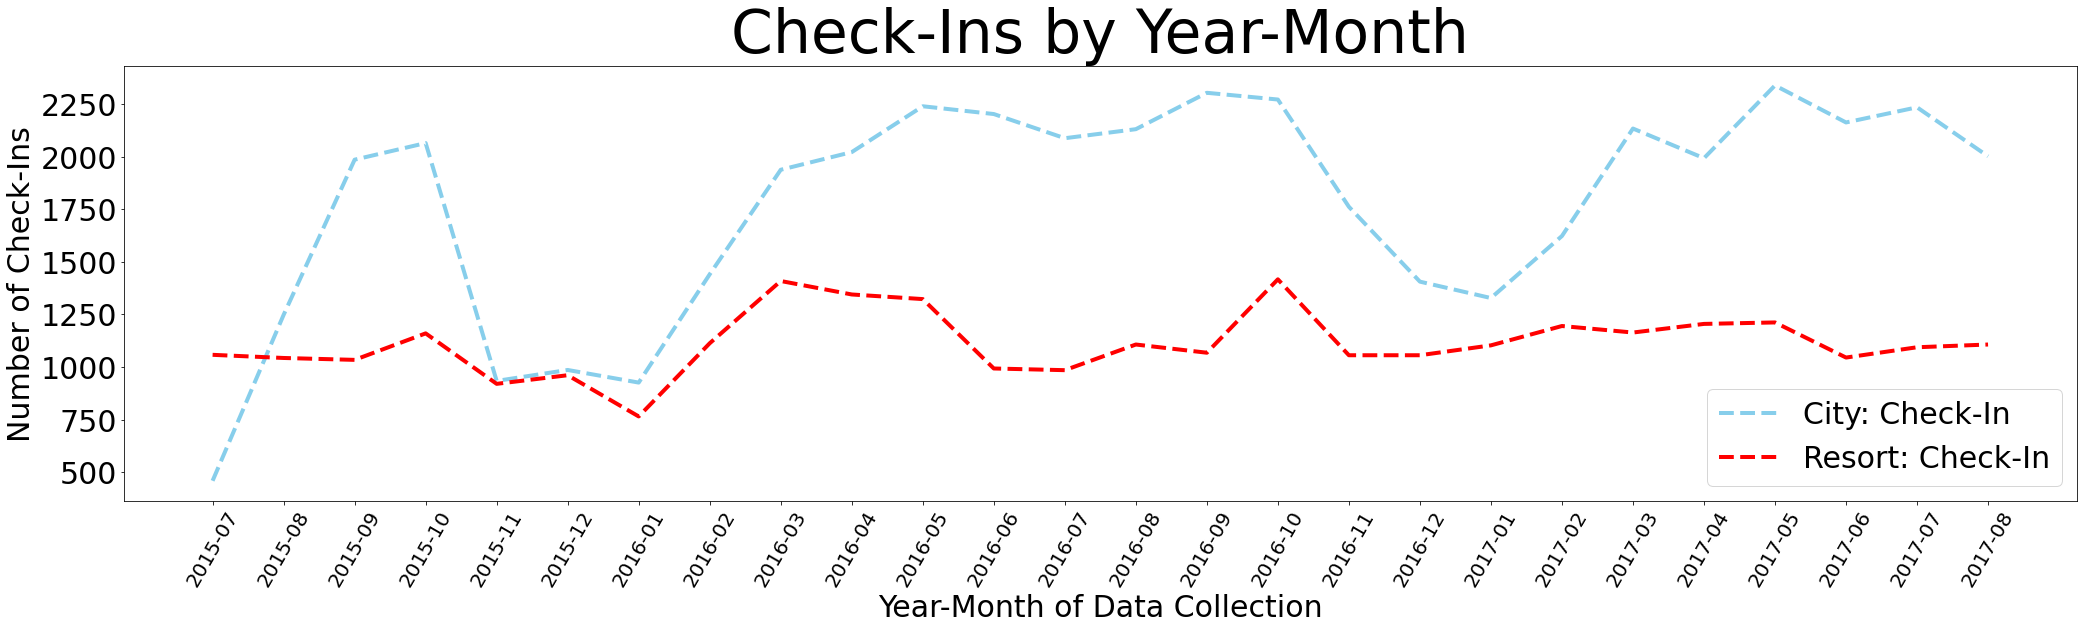

In [38]:
plt.figure(figsize=(35,8))
plt.xticks(fontsize=20, rotation=60)
plt.yticks(fontsize=30)
plt.xlabel('Year-Month of Data Collection', fontsize=30)
plt.ylabel('Number of Check-Ins', fontsize=30)
plt.title('Check-Ins by Year-Month', fontsize=60)

plt.plot('year_month', 'check_in_count', \
         data=all_check_ins_by_year_month[all_check_ins_by_year_month['hotel']=='City Hotel']\
         , color='skyblue', linewidth=4, linestyle='dashed', label='City: Check-In')
plt.plot('year_month', 'check_in_count', \
         data=all_check_ins_by_year_month[all_check_ins_by_year_month['hotel']=='Resort Hotel']\
         , color='r', linewidth=4, linestyle='dashed', label='Resort: Check-In')

plt.legend(prop={'size':30})

### Looking at the image above, one can't help but notice that the City hotel is dominating!

# Now, let's combine the number of rooms occupied.
# It's the remix! (One of those few times in history where the remix is better than the original.)

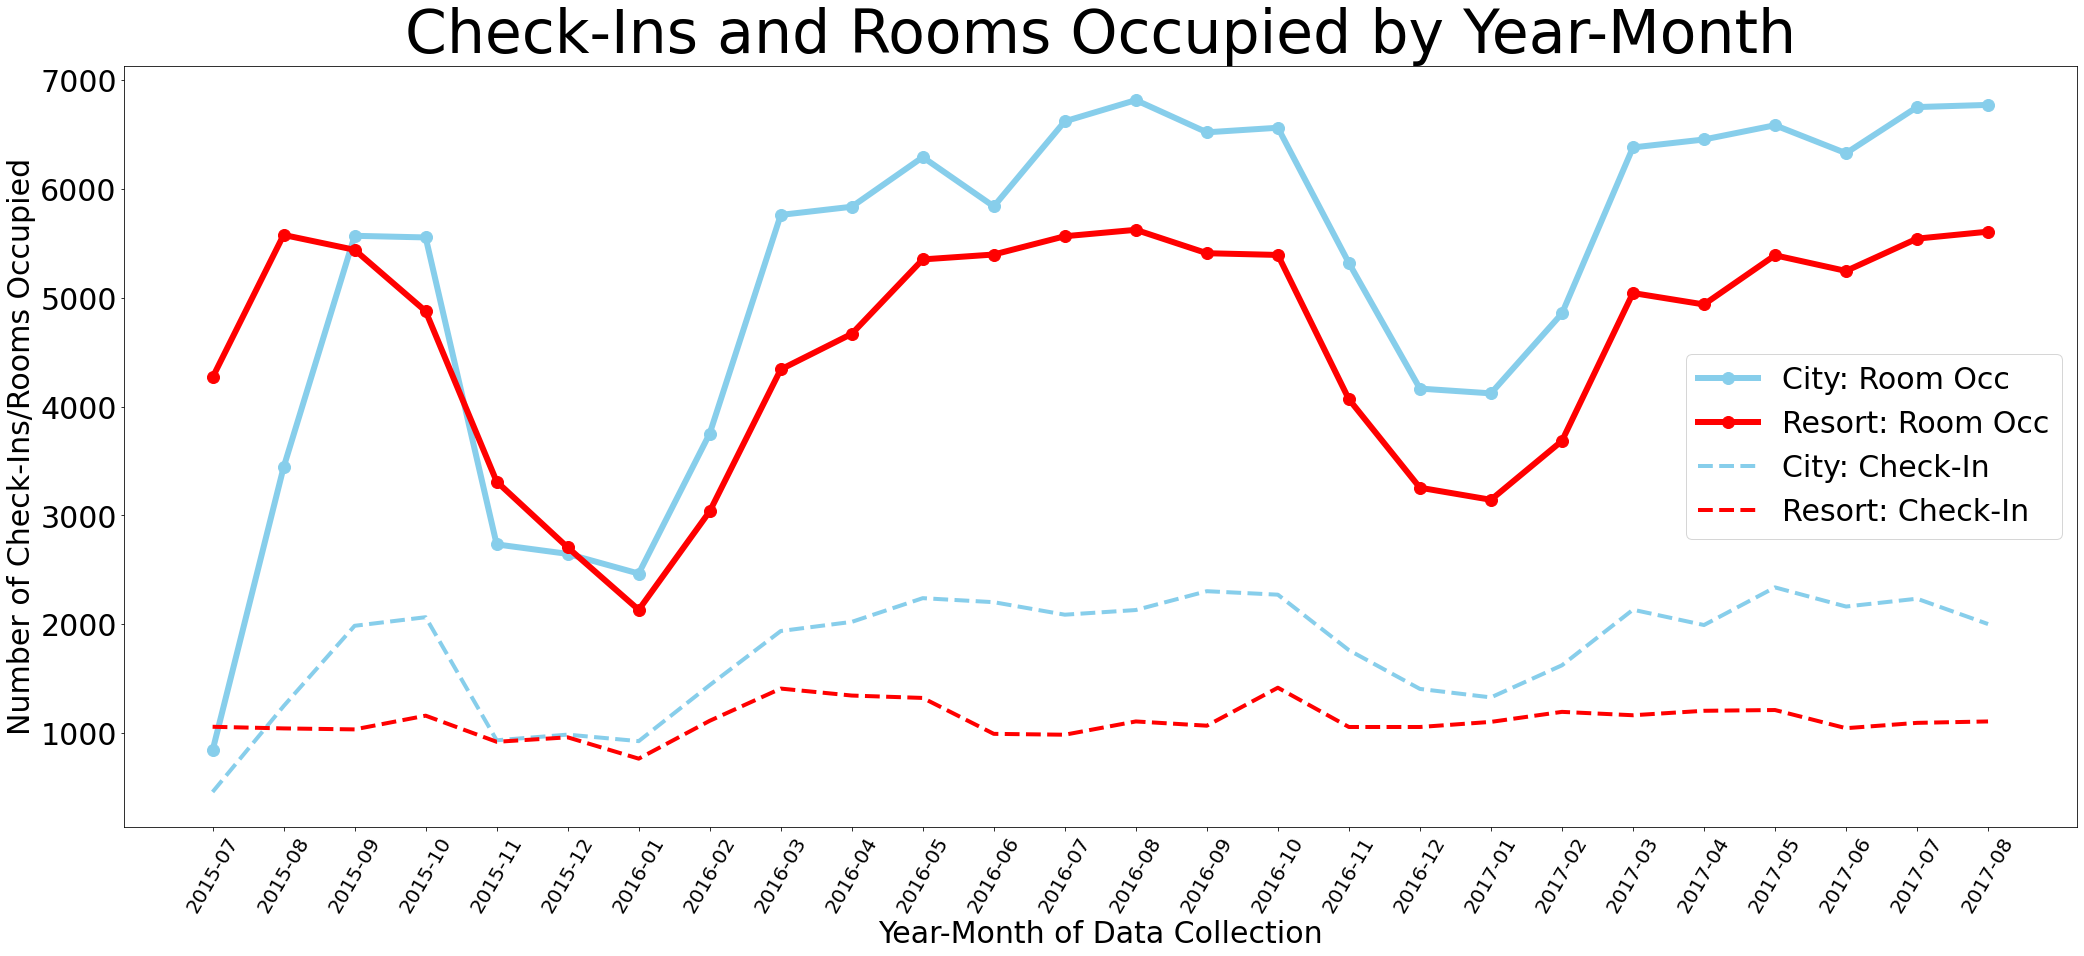

In [39]:
plt.figure(figsize=(35,14))
plt.xticks(fontsize=20, rotation=60)
plt.yticks(fontsize=30)
plt.xlabel('Year-Month of Data Collection', fontsize=30)
plt.ylabel('Number of Check-Ins/Rooms Occupied', fontsize=30)
plt.title('Check-Ins and Rooms Occupied by Year-Month', fontsize=60)

plt.plot('year_month', 'room_occupied', \
         data=all_hotel_visits_by_month[all_hotel_visits_by_month['hotel']=='City Hotel']\
         , color='skyblue', linewidth=6, marker='o', markersize=12, label='City: Room Occ')
plt.plot('year_month', 'room_occupied', \
         data=all_hotel_visits_by_month[all_hotel_visits_by_month['hotel']=='Resort Hotel']\
         , color='r', linewidth=6, marker='o', markersize=12, label='Resort: Room Occ')

plt.plot('year_month', 'check_in_count', \
         data=all_check_ins_by_year_month[all_check_ins_by_year_month['hotel']=='City Hotel']\
         , color='skyblue', linewidth=4, linestyle='dashed', label='City: Check-In')
plt.plot('year_month', 'check_in_count', \
         data=all_check_ins_by_year_month[all_check_ins_by_year_month['hotel']=='Resort Hotel']\
         , color='r', linewidth=4, linestyle='dashed', label='Resort: Check-In')

plt.legend(prop={'size':30})

### Looking at this new image above, the story starts to change.  We can clearly see the check-ins haven't changed, but we start to see some gaps closing with the Resort hotel gaining ground.

## So, what might be a final KPI that can be used to compare these two hotels?  What would be something that a Regional VP of Operations might find useful?
## What? There's a bonus hidden track on this album? (I'm not sure if that's still a thing or not.)

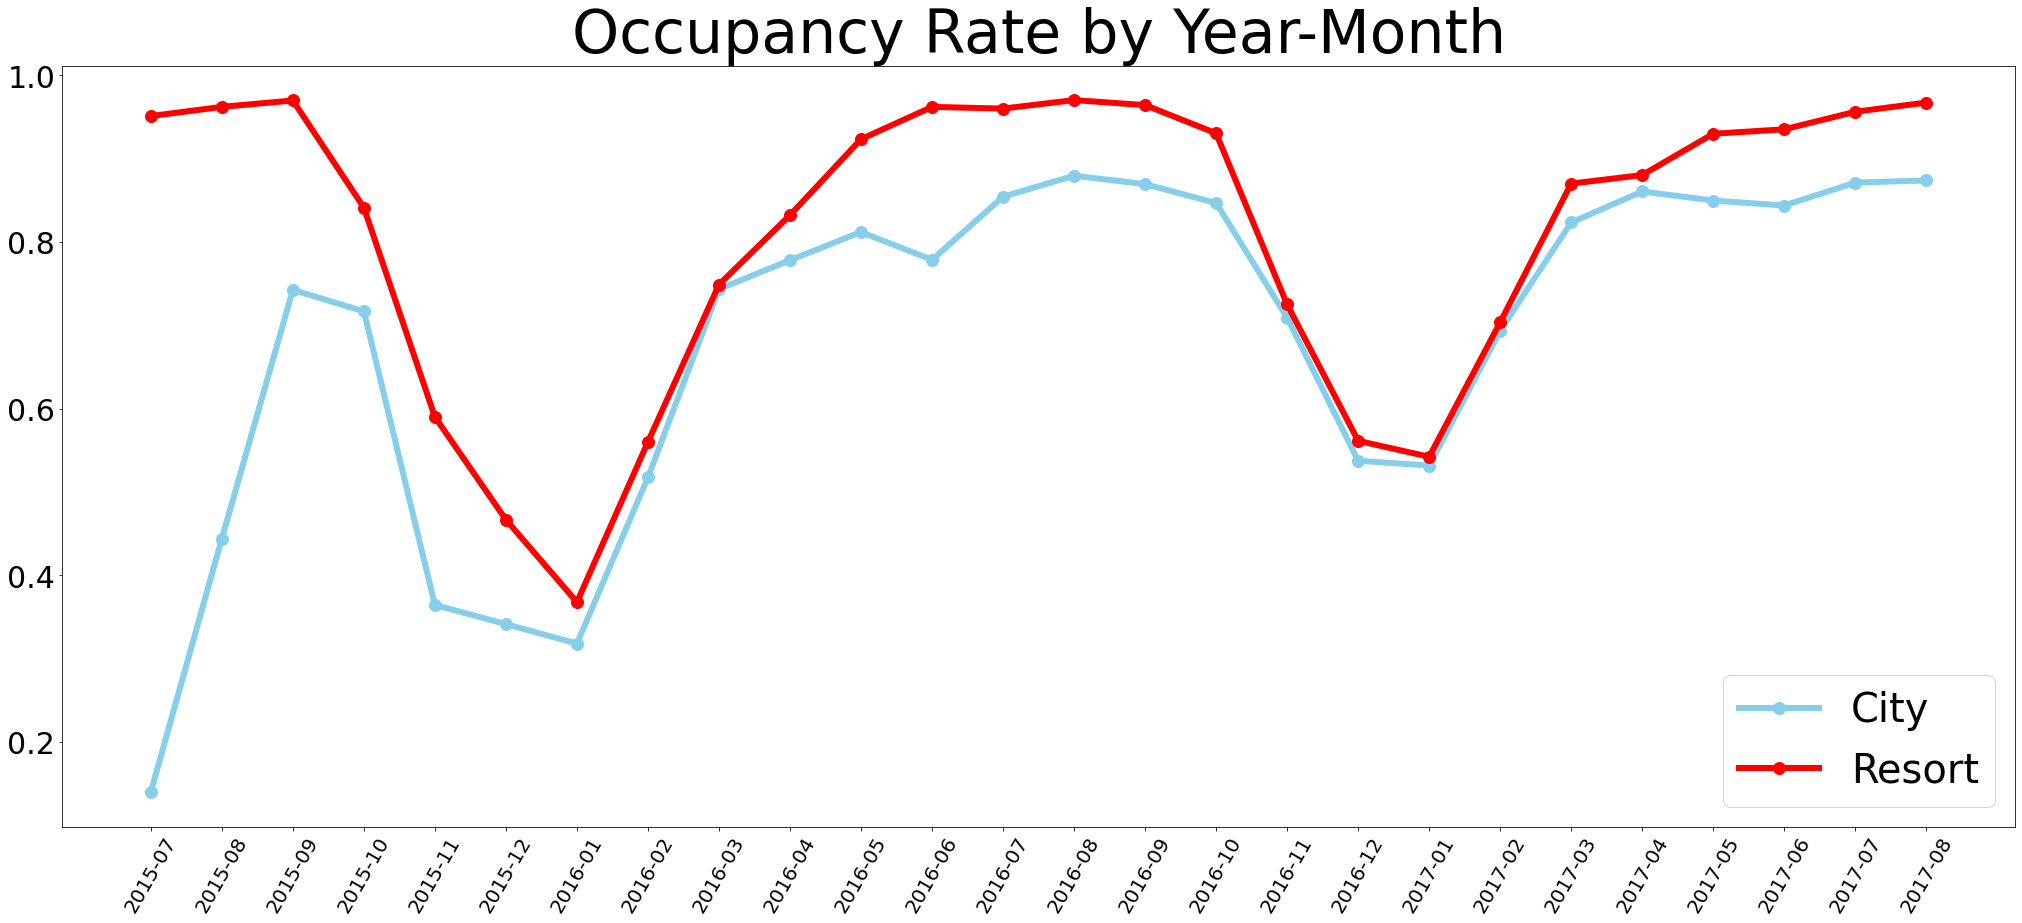

In [40]:
plt.figure(figsize=(35,14))
plt.xticks(fontsize=20, rotation=60)
plt.yticks(fontsize=30)
plt.title('Occupancy Rate by Year-Month', fontsize=60)

plt.plot('year_month', 'occ_rate', \
         data=all_hotel_visits_by_month[all_hotel_visits_by_month['hotel']=='City Hotel']\
         , color='skyblue', linewidth=6, marker='o', markersize=12, label='City')
plt.plot('year_month', 'occ_rate', \
         data=all_hotel_visits_by_month[all_hotel_visits_by_month['hotel']=='Resort Hotel']\
         , color='r', linewidth=6, marker='o', markersize=12, label='Resort')
plt.legend(loc='lower right', prop={'size':40})

### Shazam!  The resort hotel just snagged the lead at the wire.  This visualization tells a vastly different story than what we started with. 
### 1. The Resort hotel seems to be performing closer to capacity than the City hotel.  Again, this is using a proxy for what is considered max occupancy for the night based on the data available.
### 2.  There is clearly some seasonality where the warmer months (we're assuming hotels in the Northern Hemisphere based on countries like ESP, GRB, IRL in the Country column) attract more guests.  Colder months show a dip.  This will serve as our answer for H4.
### 3. We can see a trend in both hotels moving up, showing growth in the businesses.
### 4. Did the City hotel just open when the data collection began?  We're they finalizing an expansion to the building?  The max room value used is based on the highest day's room occupancy.  If there was some expansion, a different denominator might be needed for that time period.

### Other items to consider for results to compare the Resort and City Hotel:

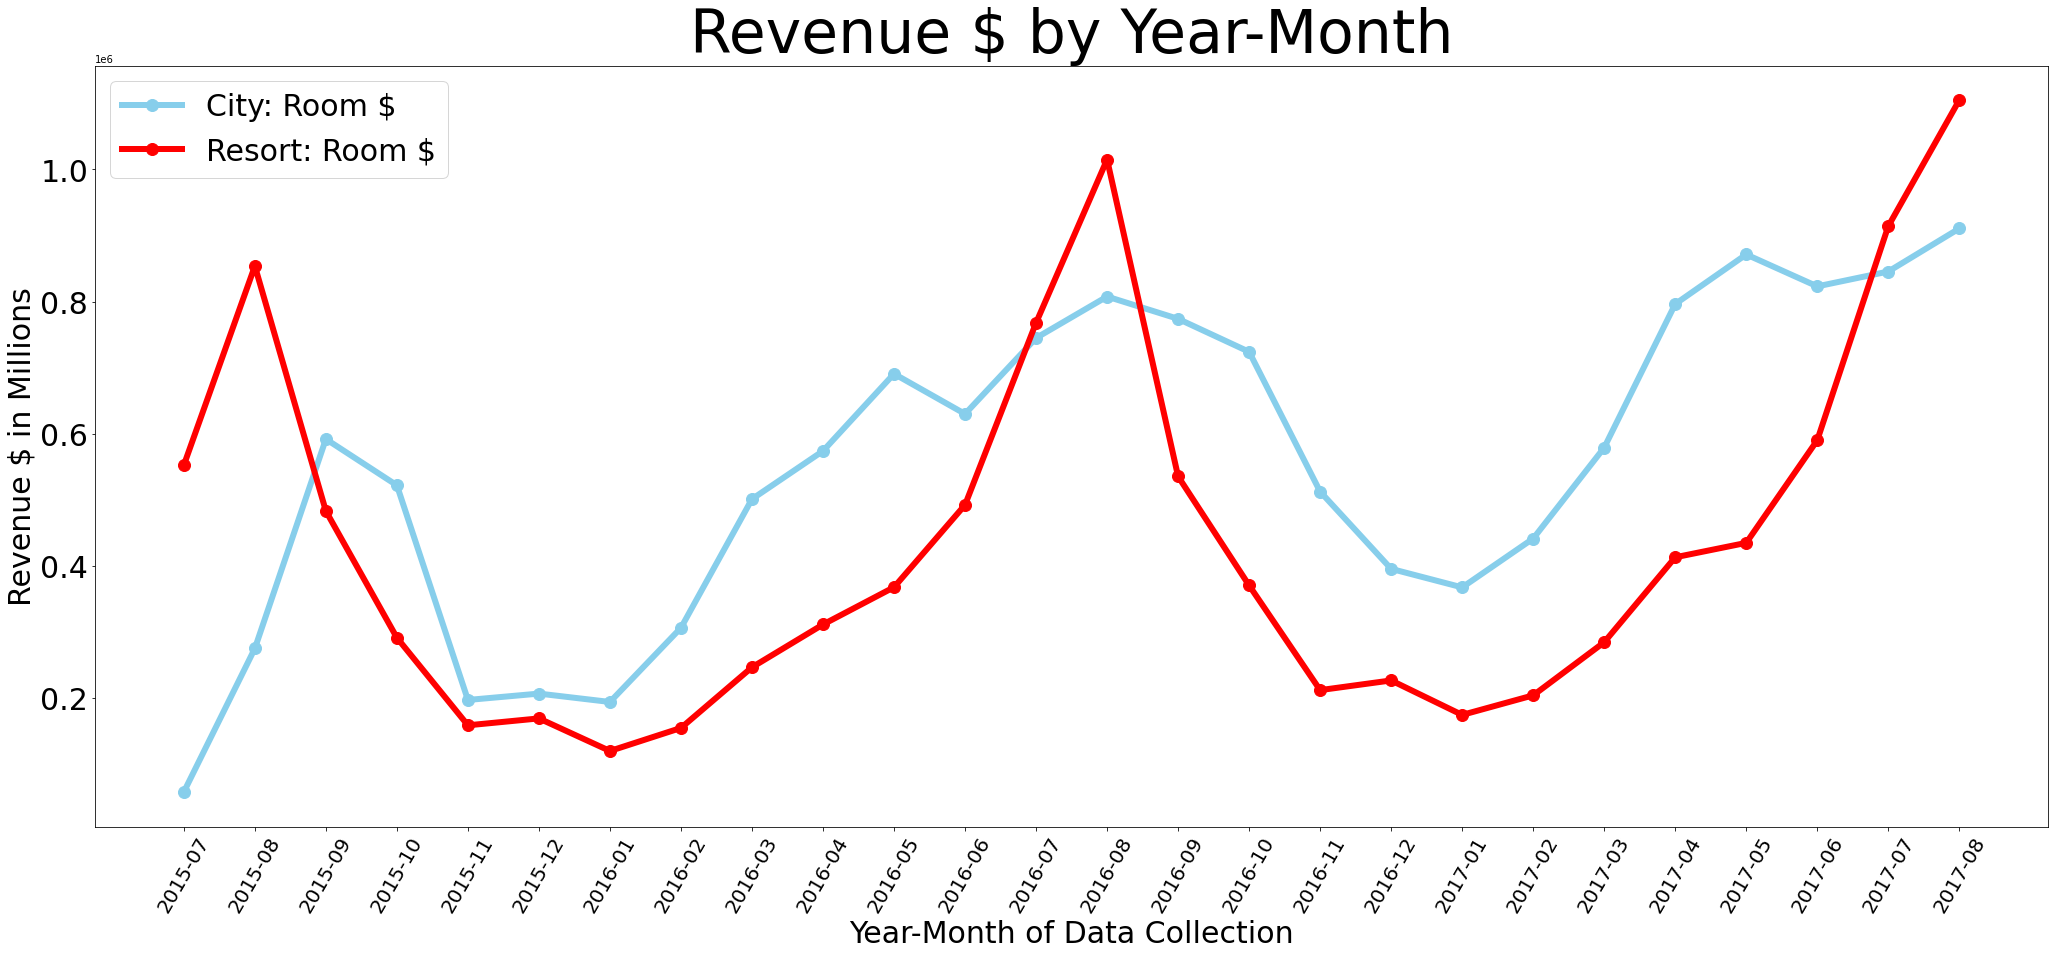

In [41]:
plt.figure(figsize=(35,14))
plt.xticks(fontsize=20, rotation=60)
plt.yticks(fontsize=30)
plt.xlabel('Year-Month of Data Collection', fontsize=30)
plt.ylabel('Revenue $ in Millions', fontsize=30)
plt.title('Revenue $ by Year-Month', fontsize=60)

plt.plot('year_month', 'adr', \
         data=all_hotel_visits_by_month[all_hotel_visits_by_month['hotel']=='City Hotel']\
         , color='skyblue', linewidth=6, marker='o', markersize=12, label='City: Room $')
plt.plot('year_month', 'adr', \
         data=all_hotel_visits_by_month[all_hotel_visits_by_month['hotel']=='Resort Hotel']\
         , color='r', linewidth=6, marker='o', markersize=12, label='Resort: Room $')

plt.legend(prop={'size':30})

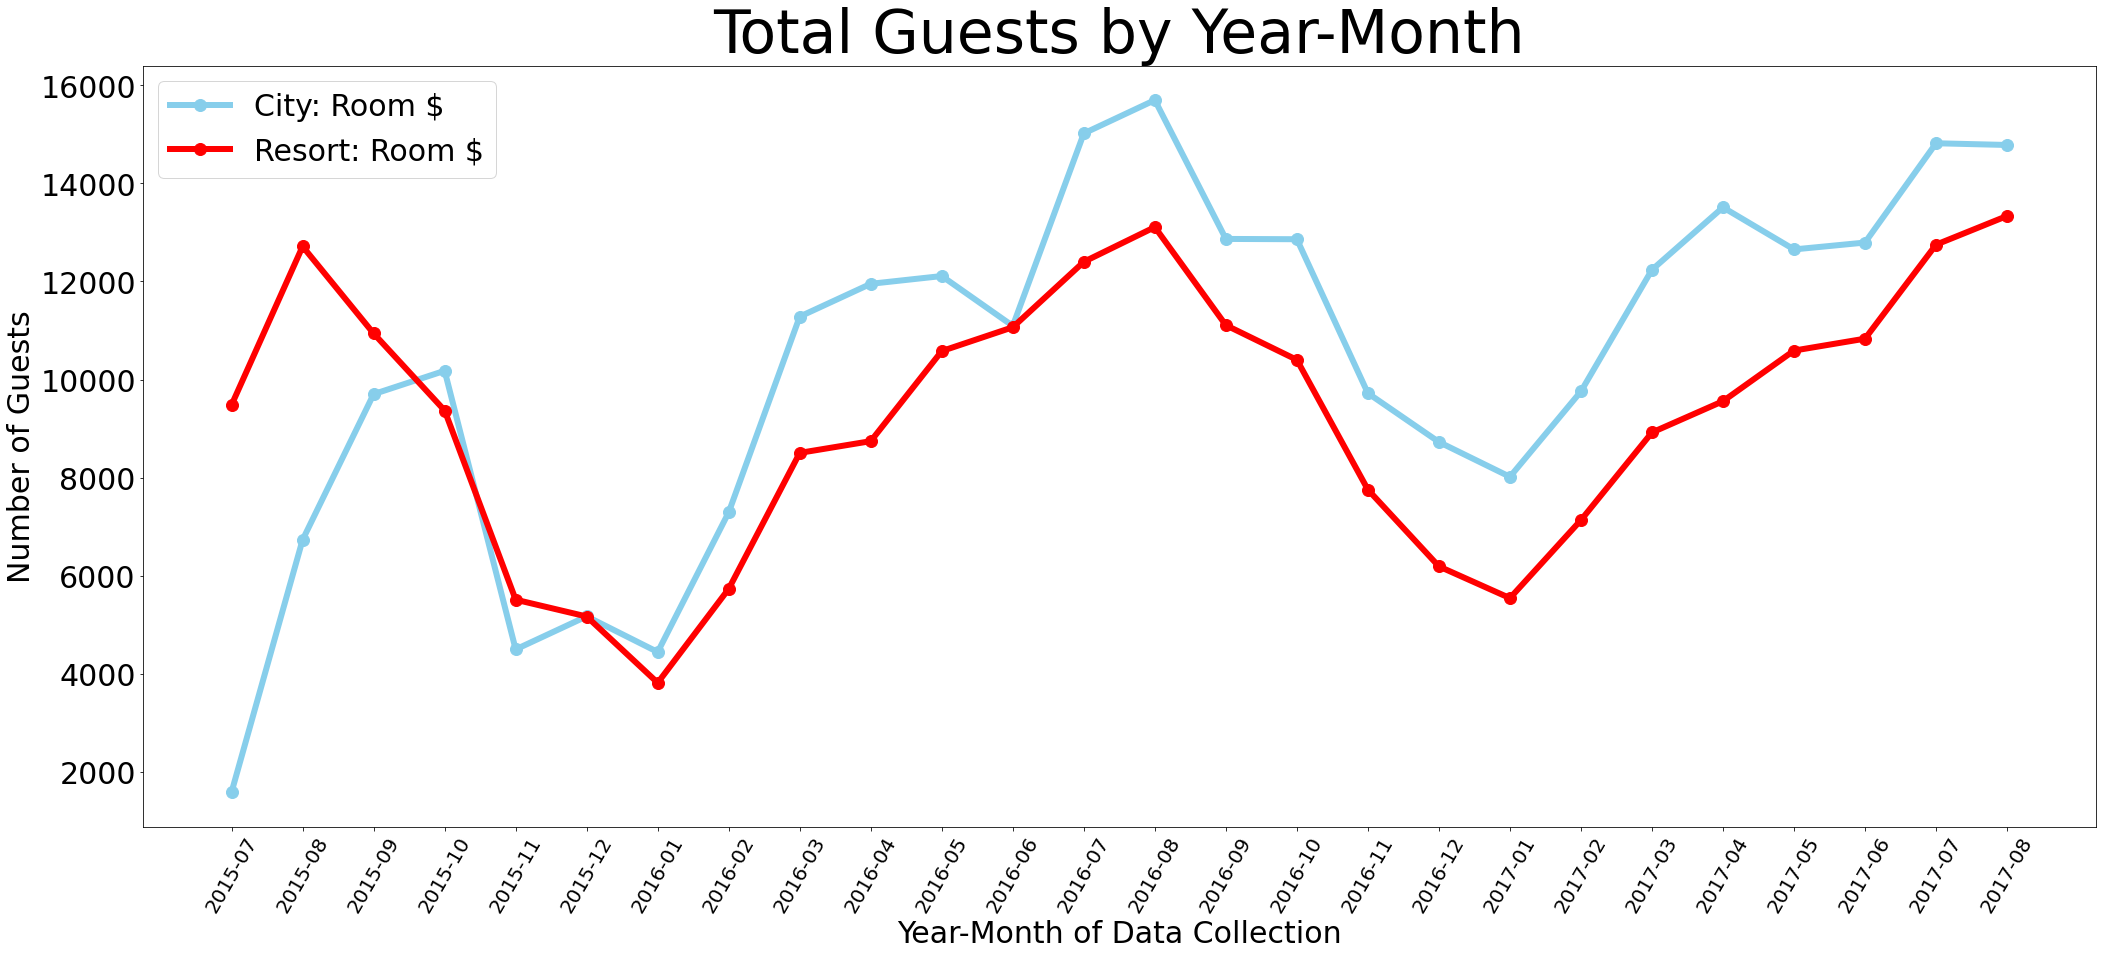

In [42]:
plt.figure(figsize=(35,14))
plt.xticks(fontsize=20, rotation=60)
plt.yticks(fontsize=30)
plt.xlabel('Year-Month of Data Collection', fontsize=30)
plt.ylabel('Number of Guests', fontsize=30)
plt.title('Total Guests by Year-Month', fontsize=60)

plt.plot('year_month', 'total_guests', \
         data=all_hotel_visits_by_month[all_hotel_visits_by_month['hotel']=='City Hotel']\
         , color='skyblue', linewidth=6, marker='o', markersize=12, label='City: Room $')
plt.plot('year_month', 'total_guests', \
         data=all_hotel_visits_by_month[all_hotel_visits_by_month['hotel']=='Resort Hotel']\
         , color='r', linewidth=6, marker='o', markersize=12, label='Resort: Room $')

plt.legend(prop={'size':30})

## Final H1/H4 Thoughts:  Comparing the two hotels really depends on what the end user is wanting to look at.  The City hotel is pulling in more revenue. 

## When it comes to revenue, we do not know things like costs to help calculate margin.  The City hotel could be bringing in a lot of revenue, but spending more in costs, which could then make the Resort hotel more profitable.

## In regards to summer months, we do see that warmer months tend to bring in more guests.

### Creating df's for H2:

In [43]:
#Create a df to aggregate count of reservations by hotel, cancel/stay, and bins
df_lead_time_bins = \
    df[['hotel', 'is_canceled', 'lead_time_bin', 'lead_time_bin_order_by', 'lead_time']]\
    .groupby(['hotel', 'is_canceled', 'lead_time_bin', 'lead_time_bin_order_by'])\
    .count().reset_index()

df_lead_time_bins.rename(columns={'lead_time':'res_count'}, inplace=True)

#Change values from 0,1 to Stayed,Canceled
df_lead_time_bins['is_canceled'] = \
    df_lead_time_bins['is_canceled'].apply(lambda x: 'Canceled' if x == 1 else 'Stayed')

df_lead_time_bins.head()

,hotel,is_canceled,lead_time_bin,lead_time_bin_order_by,res_count
0,City Hotel,Stayed,0,0,2836
1,City Hotel,Stayed,1 - 10,10,8128
2,City Hotel,Stayed,101 - 150,150,5469
3,City Hotel,Stayed,11 - 20,20,4366
4,City Hotel,Stayed,151 - 200,200,3814


In [44]:
#Create a df to house total reservation counts by hotel and bin,
#used to left join to agg table above in order to get percentages
lead_time_bin_counts = df_lead_time_bins[['hotel', 'lead_time_bin', 'res_count']]\
    .groupby(['hotel', 'lead_time_bin'], as_index=False).sum()

lead_time_bin_counts.rename(columns={'res_count':'res_count_bin'}, inplace=True)

lead_time_bin_counts.head(2)

,hotel,lead_time_bin,res_count_bin
0,City Hotel,0,3109
1,City Hotel,1 - 10,9658


In [45]:
df_lead_time_bins= df_lead_time_bins.merge(lead_time_bin_counts, \
        on=['hotel', 'lead_time_bin'], how='left', validate='many_to_one')

In [46]:
df_lead_time_bins['count_perc'] = \
    df_lead_time_bins['res_count'] / df_lead_time_bins['res_count_bin']

In [47]:
df_lead_time_bins =\
    df_lead_time_bins.sort_values(by=['hotel', 'lead_time_bin_order_by', 'is_canceled'])

df_lead_time_bins.head(6)

,hotel,is_canceled,lead_time_bin,lead_time_bin_order_by,res_count,res_count_bin,count_perc
20,City Hotel,Canceled,0,0,273,3109,0.087810
0,City Hotel,Stayed,0,0,2836,3109,0.912190
21,City Hotel,Canceled,1 - 10,10,1530,9658,0.158418
1,City Hotel,Stayed,1 - 10,10,8128,9658,0.841582
23,City Hotel,Canceled,11 - 20,20,1718,6084,0.282380
3,City Hotel,Stayed,11 - 20,20,4366,6084,0.717620


In [48]:
df_lead_time_bins_resort = df_lead_time_bins\
    [(df_lead_time_bins.lead_time_bin_order_by < 500) \
     & (df_lead_time_bins.hotel == 'Resort Hotel')]
df_lead_time_bins_resort.head(4)

,hotel,is_canceled,lead_time_bin,lead_time_bin_order_by,res_count,res_count_bin,count_perc
63,Resort Hotel,Canceled,0,0,157,3236,0.048517
42,Resort Hotel,Stayed,0,0,3079,3236,0.951483
64,Resort Hotel,Canceled,1 - 10,10,606,6849,0.088480
43,Resort Hotel,Stayed,1 - 10,10,6243,6849,0.911520


In [49]:
df_lead_time_bins_city = df_lead_time_bins\
    [(df_lead_time_bins.lead_time_bin_order_by < 600) \
     & (df_lead_time_bins.hotel == 'City Hotel')]

df_lead_time_bins_city.head(4)

,hotel,is_canceled,lead_time_bin,lead_time_bin_order_by,res_count,res_count_bin,count_perc
20,City Hotel,Canceled,0,0,273,3109,0.087810
0,City Hotel,Stayed,0,0,2836,3109,0.912190
21,City Hotel,Canceled,1 - 10,10,1530,9658,0.158418
1,City Hotel,Stayed,1 - 10,10,8128,9658,0.841582


In [50]:
#Values for resort
#Check-Out
x_checkout_resort = [label_bin for label_bin, df in \
              df_lead_time_bins_resort\
              [df_lead_time_bins_resort.is_canceled == 'Stayed']\
             .groupby('lead_time_bin_order_by')]
    
checkout_vals_resort = df_lead_time_bins_resort['count_perc']\
        [df_lead_time_bins_resort.is_canceled == 'Stayed']

#Canc:
x_canc_resort = [label_bin for label_bin, df in \
              df_lead_time_bins_resort\
                [df_lead_time_bins_resort.is_canceled == 'Canceled']\
             .groupby('lead_time_bin_order_by')]
    
canc_vals_resort = df_lead_time_bins_resort['count_perc']\
        [df_lead_time_bins_resort.is_canceled == 'Canceled']

In [51]:
#Values for City
#Check-Out
x_checkout_city = [label_bin for label_bin, df in \
              df_lead_time_bins_city\
              [df_lead_time_bins_city.is_canceled == 'Stayed']\
             .groupby('lead_time_bin_order_by')]
    
checkout_vals_city = df_lead_time_bins_city['count_perc']\
        [df_lead_time_bins_city.is_canceled == 'Stayed']

#Canc:
x_canc_city = [label_bin for label_bin, df in \
              df_lead_time_bins_city\
                [df_lead_time_bins_city.is_canceled == 'Canceled']\
             .groupby('lead_time_bin_order_by')]
    
canc_vals_city = df_lead_time_bins_city['count_perc']\
        [df_lead_time_bins_city.is_canceled == 'Canceled']

In [52]:
line_perc_df_resort = \
    df_lead_time_bins_resort[['lead_time_bin_order_by', 'lead_time_bin', 'res_count']]\
    .groupby(['lead_time_bin_order_by', 'lead_time_bin']).sum().reset_index()

line_perc_df_resort['total_res_count'] = line_perc_df_resort['res_count'].sum()

line_perc_df_resort['bin_perc_of_res'] = \
    line_perc_df_resort['res_count'] / line_perc_df_resort['total_res_count']

line_perc_df_resort.head(3)

,lead_time_bin_order_by,lead_time_bin,res_count,total_res_count,bin_perc_of_res
0,0,0,3236,39956,0.080989
1,10,1 - 10,6849,39956,0.171414
2,20,11 - 20,2913,39956,0.072905


In [53]:
line_perc_df_city = \
    df_lead_time_bins_city[['lead_time_bin_order_by', 'lead_time_bin', 'res_count']]\
    .groupby(['lead_time_bin_order_by', 'lead_time_bin']).sum().reset_index()

line_perc_df_city['total_res_count'] = line_perc_df_city['res_count'].sum()

line_perc_df_city['bin_perc_of_res'] = \
    line_perc_df_city['res_count'] / line_perc_df_city['total_res_count']

line_perc_df_city.head(3)

,lead_time_bin_order_by,lead_time_bin,res_count,total_res_count,bin_perc_of_res
0,0,0,3109,79066,0.039322
1,10,1 - 10,9658,79066,0.122151
2,20,11 - 20,6084,79066,0.076948


In [54]:
x_tick_labels_resort = line_perc_df_resort['lead_time_bin']

In [55]:
x_tick_labels_city = line_perc_df_city['lead_time_bin']

# H2 Viz. Long lead times will increase the possibility of a customer cancelling.

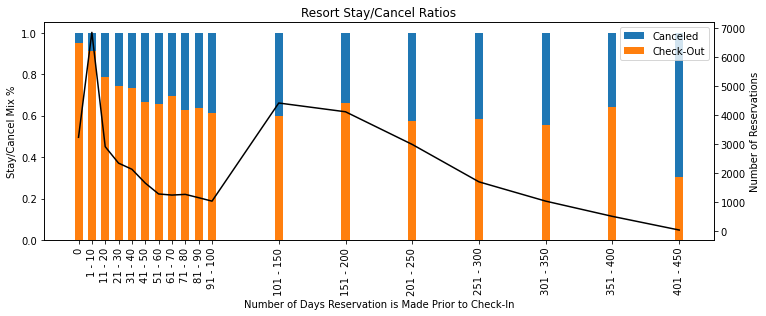

In [56]:
width = 6
plt.figure(figsize=(12, 4))

p1 = plt.bar(x_canc_resort, canc_vals_resort, width=width, bottom=checkout_vals_resort)
p2 = plt.bar(x_checkout_resort, checkout_vals_resort, width=width)

plt.ylabel('Stay/Cancel Mix %')
plt.xlabel('Number of Days Reservation is Made Prior to Check-In')
plt.xticks(ticks=x_checkout_resort, labels=x_tick_labels_resort, rotation='vertical')
plt.title('Resort Stay/Cancel Ratios')

x_resort = x_canc_resort
y_resort = line_perc_df_resort['res_count']
axes2 = plt.twinx()
axes2.plot(x_resort, y_resort, color='k')
axes2.set_ylabel('Number of Reservations')

plt.legend((p1[0], p2[0]), ('Canceled', 'Check-Out'), loc=0)

plt.show()

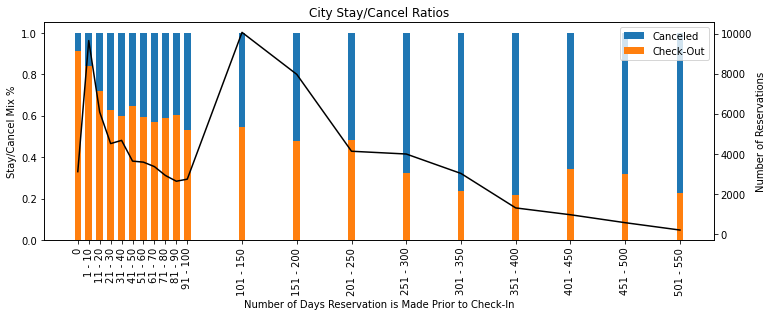

In [57]:
width = 6
plt.figure(figsize=(12, 4))

p1 = plt.bar(x_canc_city, canc_vals_city, width=width, bottom=checkout_vals_city)
p2 = plt.bar(x_checkout_city, checkout_vals_city, width=width)

plt.ylabel('Stay/Cancel Mix %')
plt.xlabel('Number of Days Reservation is Made Prior to Check-In')
plt.xticks(ticks=x_checkout_city, labels=x_tick_labels_city, rotation='vertical')
plt.title('City Stay/Cancel Ratios')

x_city = x_canc_city
y_city = line_perc_df_city['res_count']
axes2 = plt.twinx()
axes2.plot(x_city, y_city, color='k')
axes2.set_ylabel('Number of Reservations')

plt.legend((p1[0], p2[0]), ('Canceled', 'Check-Out'), loc=0)

plt.show()

## Final H2 Thoughts:

## What stands out here?  Looking at the both hotels, we would expect a rise in our 'Number of Reservations' line at the 100 break as we are switching to groups of 10 days to 50 days.  The thing that stands out is the higher number of reservations at the City hotel and the increased percentage of cancelled reservations in this group.

### Creating df's for H3:

In [58]:
low_adr_grouped = df[['hotel', 'charge_no_charge', 'is_canceled','lead_time']]\
    .groupby(['hotel', 'charge_no_charge', 'is_canceled']).count().reset_index()

low_adr_grouped.rename(columns={'lead_time':'res_count'}, inplace=True)

#Change values from 0,1 to Stayed,Canceled
low_adr_grouped['is_canceled'] = \
    low_adr_grouped['is_canceled'].apply(lambda x: 'Did Not Stay' if x == 1 else 'Checked-In')

low_adr_grouped

,hotel,charge_no_charge,is_canceled,res_count
0,City Hotel,Charge,Checked-In,45149
1,City Hotel,Charge,Did Not Stay,32973
2,City Hotel,No Charge,Checked-In,1079
3,City Hotel,No Charge,Did Not Stay,129
4,Resort Hotel,Charge,Checked-In,28270
5,Resort Hotel,Charge,Did Not Stay,11038
6,Resort Hotel,No Charge,Checked-In,668
7,Resort Hotel,No Charge,Did Not Stay,84


In [59]:
totals_low_adr = low_adr_grouped[['hotel', 'charge_no_charge', 'res_count']]\
    .groupby(['hotel', 'charge_no_charge']).sum().reset_index()

totals_low_adr.rename(columns={'res_count':'group_res_count'}, inplace=True)

totals_low_adr

,hotel,charge_no_charge,group_res_count
0,City Hotel,Charge,78122
1,City Hotel,No Charge,1208
2,Resort Hotel,Charge,39308
3,Resort Hotel,No Charge,752


In [60]:
low_adr_grouped = low_adr_grouped.merge(totals_low_adr, \
        on=['hotel', 'charge_no_charge'], how='left', validate='many_to_one')

low_adr_grouped['res_percent'] = \
    low_adr_grouped['res_count'] / low_adr_grouped['group_res_count']

low_adr_grouped

,hotel,charge_no_charge,is_canceled,res_count,group_res_count,res_percent
0,City Hotel,Charge,Checked-In,45149,78122,0.577929
1,City Hotel,Charge,Did Not Stay,32973,78122,0.422071
2,City Hotel,No Charge,Checked-In,1079,1208,0.893212
3,City Hotel,No Charge,Did Not Stay,129,1208,0.106788
4,Resort Hotel,Charge,Checked-In,28270,39308,0.719192
5,Resort Hotel,Charge,Did Not Stay,11038,39308,0.280808
6,Resort Hotel,No Charge,Checked-In,668,752,0.888298
7,Resort Hotel,No Charge,Did Not Stay,84,752,0.111702


In [61]:
#Values for Resort
#Checked-in
x_checked_in_resort = [label_bin for label_bin, df in \
              low_adr_grouped\
              [(low_adr_grouped.is_canceled == 'Checked-In')\
              & (low_adr_grouped.hotel == 'Resort Hotel')]\
             .groupby('charge_no_charge')]
    
checked_in_vals_resort = low_adr_grouped['res_percent']\
        [(low_adr_grouped.hotel == 'Resort Hotel')\
        & (low_adr_grouped.is_canceled == 'Checked-In')]

#Did not Check-in
x_not_checked_in_resort = [label_bin for label_bin, df in \
              low_adr_grouped\
              [(low_adr_grouped.is_canceled == 'Did Not Stay')\
              & (low_adr_grouped.hotel == 'Resort Hotel')]\
             .groupby('charge_no_charge')]
    
not_checked_in_vals_resort = low_adr_grouped['res_percent']\
        [(low_adr_grouped.hotel == 'Resort Hotel')\
        & (low_adr_grouped.is_canceled == 'Did Not Stay')]

In [62]:
#Values for City
#Checked-in
x_checked_in_city = [label_bin for label_bin, df in \
              low_adr_grouped\
              [(low_adr_grouped.is_canceled == 'Checked-In')\
              & (low_adr_grouped.hotel == 'City Hotel')]\
             .groupby('charge_no_charge')]
    
checked_in_vals_city = low_adr_grouped['res_percent']\
        [(low_adr_grouped.hotel == 'City Hotel')\
        & (low_adr_grouped.is_canceled == 'Checked-In')]

#Did not Check-in
x_not_checked_in_city = [label_bin for label_bin, df in \
              low_adr_grouped\
              [(low_adr_grouped.is_canceled == 'Did Not Stay')\
              & (low_adr_grouped.hotel == 'City Hotel')]\
             .groupby('charge_no_charge')]
    
not_checked_in_vals_city = low_adr_grouped['res_percent']\
        [(low_adr_grouped.hotel == 'City Hotel')\
        & (low_adr_grouped.is_canceled == 'Did Not Stay')]

# H3 Viz. With some visits listed as /$0 ADR, these reservations will see fewer cancellations.

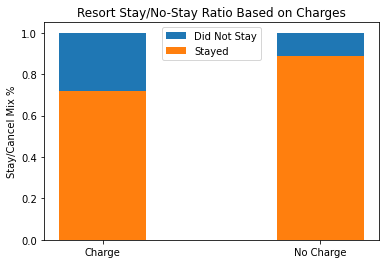

In [63]:
width = .4
plt.figure(figsize=(6, 4))

p1 = plt.bar(x_not_checked_in_resort, not_checked_in_vals_resort, \
             width=width, bottom=checked_in_vals_resort)
p2 = plt.bar(x_checked_in_resort, checked_in_vals_resort, width=width)

plt.ylabel('Stay/Cancel Mix %')
plt.title('Resort Stay/No-Stay Ratio Based on Charges')

plt.legend((p1[0], p2[0]), ('Did Not Stay', 'Stayed'), loc=9)

plt.show()

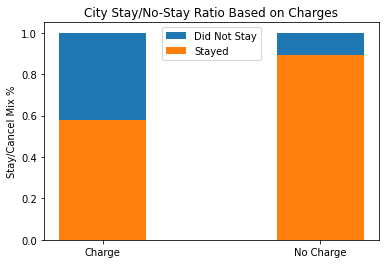

In [64]:
width = .4
plt.figure(figsize=(6, 4))

p1 = plt.bar(x_not_checked_in_city, not_checked_in_vals_city, \
             width=width, bottom=checked_in_vals_city)
p2 = plt.bar(x_checked_in_city, checked_in_vals_city, width=width)

plt.ylabel('Stay/Cancel Mix %')
plt.title('City Stay/No-Stay Ratio Based on Charges')

plt.legend((p1[0], p2[0]), ('Did Not Stay', 'Stayed'), loc=9)

plt.show()

## Final H3 Thoughts:

## Looking at this, we can see that guests that are not paying for their rooms will actually stay, as expected.  This isn't some major breakthrough.  What this can mean though could be an e-mail blast targeting these groups of guests with a marketing strategy built around value added products, such as discounted amenities or meals.  

## Here's the scenario: a guest stays 5 times and earns a free night's stay.  They stay the free night, but don't spend any money at the hotel because they go out to eat and enjoy the surrounding area.  The hotel can grow in customer satisfaction, but being able to make some revenue from the guest during this stay could be very beneficial in covering costs.

### Creating df's for H5:

In [65]:
deposit_df = df[['hotel', 'is_canceled', 'deposit_type', 'lead_time']]\
    [df['deposit_type'] != 'Refundable']\
    .groupby(['hotel', 'is_canceled', 'deposit_type']).count().reset_index()

deposit_df.rename(columns={'lead_time':'res_count'}, inplace=True)

deposit_df['is_canceled'] = \
    deposit_df['is_canceled'].apply(lambda x: 'Did Not Stay' if x == 1 else 'Checked-In')


In [66]:
deposit_df_grouped = deposit_df[['hotel', 'deposit_type', 'res_count']]\
    .groupby(['hotel', 'deposit_type']).sum().reset_index()

deposit_df_grouped.rename(columns={'res_count':'group_res_count'}, inplace=True)

deposit_df_grouped

,hotel,deposit_type,group_res_count
0,City Hotel,No Deposit,66442
1,City Hotel,Non Refund,12868
2,Resort Hotel,No Deposit,38199
3,Resort Hotel,Non Refund,1719


In [67]:
deposit_df = deposit_df.merge(deposit_df_grouped, \
        on=['hotel', 'deposit_type'], how='left', validate='many_to_one')

deposit_df['res_percent'] = \
    deposit_df['res_count'] / deposit_df['group_res_count']

deposit_df

,hotel,is_canceled,deposit_type,res_count,group_res_count,res_percent
0,City Hotel,Checked-In,No Deposit,46198,66442,0.695313
1,City Hotel,Checked-In,Non Refund,24,12868,0.001865
2,City Hotel,Did Not Stay,No Deposit,20244,66442,0.304687
3,City Hotel,Did Not Stay,Non Refund,12844,12868,0.998135
4,Resort Hotel,Checked-In,No Deposit,28749,38199,0.752611
5,Resort Hotel,Checked-In,Non Refund,69,1719,0.040140
6,Resort Hotel,Did Not Stay,No Deposit,9450,38199,0.247389
7,Resort Hotel,Did Not Stay,Non Refund,1650,1719,0.959860


In [68]:
#Values for Resort
#Checked-in
x_checked_in_resort = [label_bin for label_bin, df in \
              deposit_df\
              [(deposit_df.is_canceled == 'Checked-In')\
              & (deposit_df.hotel == 'Resort Hotel')]\
             .groupby('deposit_type')]
    
checked_in_vals_resort = deposit_df['res_percent']\
        [(deposit_df.hotel == 'Resort Hotel')\
        & (deposit_df.is_canceled == 'Checked-In')]

#Did not Check-in
x_not_checked_in_resort = [label_bin for label_bin, df in \
              deposit_df\
              [(deposit_df.is_canceled == 'Did Not Stay')\
              & (deposit_df.hotel == 'Resort Hotel')]\
             .groupby('deposit_type')]
    
not_checked_in_vals_resort = deposit_df['res_percent']\
        [(deposit_df.hotel == 'Resort Hotel')\
        & (deposit_df.is_canceled == 'Did Not Stay')]

In [69]:
#Values for City
#Checked-in
x_checked_in_city = [label_bin for label_bin, df in \
              deposit_df\
              [(deposit_df.is_canceled == 'Checked-In')\
              & (deposit_df.hotel == 'City Hotel')]\
             .groupby('deposit_type')]
    
checked_in_vals_city = deposit_df['res_percent']\
        [(deposit_df.hotel == 'City Hotel')\
        & (deposit_df.is_canceled == 'Checked-In')]

#Did not Check-in
x_not_checked_in_city = [label_bin for label_bin, df in \
              deposit_df\
              [(deposit_df.is_canceled == 'Did Not Stay')\
              & (deposit_df.hotel == 'City Hotel')]\
             .groupby('deposit_type')]
    
not_checked_in_vals_city = deposit_df['res_percent']\
        [(deposit_df.hotel == 'City Hotel')\
        & (deposit_df.is_canceled == 'Did Not Stay')]

# H5 Viz. Customers with non-refundable deposits will cancel/no-show less.

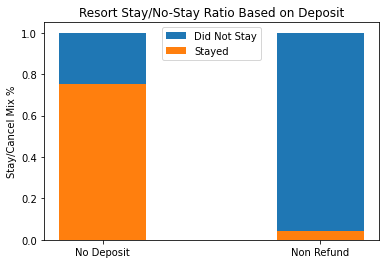

In [70]:
width = .4
plt.figure(figsize=(6, 4))

p1 = plt.bar(x_not_checked_in_resort, not_checked_in_vals_resort, \
             width=width, bottom=checked_in_vals_resort)
p2 = plt.bar(x_checked_in_resort, checked_in_vals_resort, width=width)

plt.ylabel('Stay/Cancel Mix %')
plt.title('Resort Stay/No-Stay Ratio Based on Deposit')

plt.legend((p1[0], p2[0]), ('Did Not Stay', 'Stayed'), loc=9)

plt.show()

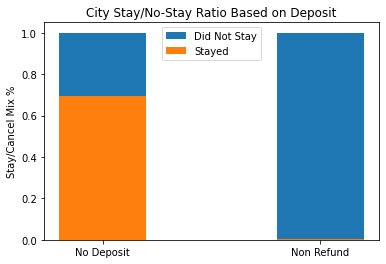

In [71]:
width = .4
plt.figure(figsize=(6, 4))

p1 = plt.bar(x_not_checked_in_city, not_checked_in_vals_city, \
             width=width, bottom=checked_in_vals_city)
p2 = plt.bar(x_checked_in_city, checked_in_vals_city, width=width)

plt.ylabel('Stay/Cancel Mix %')
plt.title('City Stay/No-Stay Ratio Based on Deposit')

plt.legend((p1[0], p2[0]), ('Did Not Stay', 'Stayed'), loc=9)

plt.show()

## Final H5 Thoughts:

## This is a little shocking.  The percent of customers that are willing to forfeit their non-refundable deposit is rather high.  What can this mean to the business?  If these guests are reserving rooms during peak season, the hotel might see them cancel and keep the non-refundable deposit and still be able to book the room for someone else.  If these reservations are during slower months, these reservations might be identified to try and entice the guest to still visit, maybe with discounted amenties at the resort.

# Additional Recommendations/Thoughts:

## Data Wants:

### I would like to verify the accuracy of some of the data based on the discrepancies corrected in the cleaning process.

### Having daily/monthly costs would be great to add to further comparisons.

### Having deposit amounts would be benficial as well.  We see a lot of reservations with non-refundable deposits not checking in.  What sort of impact is that making financially?

### Seeing the number of guests makes me wonder about revenue from value added products like restaurants, spas, etc.  Does one hotel have a lot more to offer than the other, which could lead to better financial results?

In [105]:
#Grouping cancel rates into 10's: 0%, 1-10% becomes 10, etc.
#New guests are assigned -1, so 0% is for guests that have
#truly never canceled.
canc_rate_round = []

for index,row in df.iterrows():
    if row['is_repeated_guest'] == 0:
        canc_rate_round.append(-1)
    else:
        canc_rate_round.append((math.ceil(row['cancel_rate'] * 10) * 10))
    
df['cancel_rate_round'] = canc_rate_round

df[df.cancel_rate > 0].head(10).T

,13805,13811,13825,13826,13827,13855,13856,13857,13858,13864
hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel
is_canceled,1,1,0,0,0,0,0,0,0,1
lead_time,2,71,6,7,8,5,0,7,5,92
year,2016,2016,2016,2016,2016,2015,2015,2016,2016,2016
arrival_date_month,October,July,March,June,September,November,December,January,April,July
arrival_date_week_number,42,29,13,26,40,48,52,4,15,29
day,12,14,21,21,27,25,22,18,5,16
stays_in_weekend_nights,0,3,1,0,0,0,0,1,0,4
stays_in_week_nights,2,8,0,1,2,1,1,3,2,6
adults,1,2,1,1,2,1,1,1,1,2


In [108]:
df[['cancel_rate_round', 'is_canceled', 'arrival_date']]\
    .groupby(['cancel_rate_round', 'is_canceled']).count()

arrival_date
cancel_rate_round is_canceled              
-1                0                   71721
                  1                   38212
 0                0                    2903
                  1                      70
 10               0                     170
                  1                      10
 20               0                     187
                  1                      25
 30               0                      61
                  1                      17
 40               0                      40
                  1                      21
 50               0                      36
                  1                      35
 60               0                       4
                  1                       5
 70               0                      10
                  1                       6
 80               0                       8
 100              0                      26
                  1                    5823

## If a guest is a repeat customer and has never cancelled, 0% cancels, they tend to not cancel again.  In the group that had already canceled 100% of their visits, they leaned towards another cancel.

In [119]:
df[['hotel', 'is_canceled', 'arrival_date']]\
    .loc[(df.stays_in_week_nights > 2) & (df.stays_in_weekend_nights == 0)]\
    .groupby(['hotel', 'is_canceled']).count()

arrival_date
hotel        is_canceled              
City Hotel   0                    7296
             1                    5457
Resort Hotel 0                    2846
             1                    1277

In [123]:
df[['hotel', 'reserved_room_type', 'adr']]\
    .groupby(['hotel', 'reserved_room_type']).mean()

adr
hotel        reserved_room_type            
City Hotel   A                    96.249209
             B                    90.321955
             C                    85.482143
             D                   131.461437
             E                   156.796864
             F                   189.259140
             G                   201.800496
             P                     0.000000
Resort Hotel A                    76.210733
             B                   104.666667
             C                   161.356536
             D                   103.618166
             E                   114.485054
             F                   132.761121
             G                   168.238658
             H                   188.223111
             L                   124.666667
             P                     0.000000

In [122]:
df[['hotel', 'is_canceled', 'reserved_room_type', 'assigned_room_type', 'adr']]\
    .loc[df.reserved_room_type != df.assigned_room_type]

,hotel,is_canceled,reserved_room_type,assigned_room_type,adr
2,Resort Hotel,0,A,C,75.00
12,Resort Hotel,0,D,E,97.00
15,Resort Hotel,0,D,E,97.00
17,Resort Hotel,0,A,E,88.20
18,Resort Hotel,0,A,G,107.42
24,Resort Hotel,0,D,I,94.95
33,Resort Hotel,0,A,C,65.50
36,Resort Hotel,0,A,C,98.00
48,Resort Hotel,0,A,B,82.35
49,Resort Hotel,0,E,F,119.35


## If the hotel assigns a different room type, it's assumed it's an upgrade due to over booking.  Looking at average rates for reserved rooms, these numbers tend to support that.

In [125]:
df[['hotel', 'is_canceled', 'reserved_room_type', 'assigned_room_type']]\
    .loc[df.reserved_room_type != df.assigned_room_type]\
    .groupby(['hotel', 'assigned_room_type', 'is_canceled']).count()

reserved_room_type
hotel        assigned_room_type is_canceled                    
City Hotel   A                  0                           411
                                1                            15
             B                  0                           882
                                1                           137
             C                  0                           140
                                1                            10
             D                  0                          3841
                                1                           166
             E                  0                           695
                                1                            43
             F                  0                           312
                                1                            23
             G                  0                           226
                                1                            12
             K                  0                           267
                                1                            12
Resort Hotel A                  0                            28
                                1                             1
             B                  0                           147
                                1                             9
             C                  0                          1211
                                1                           131
             D                  0                          3424
                                1                           155
             E                  0                          1106
                                1                            39
             F                  0                           679
                                1                            30
             G                  0                           266
                                1                             8
             H                  0                           122
                                1                             6
             I                  0                           358
                                1                             5

In [126]:
df[['hotel', 'is_canceled', 'assigned_room_type']]\
    .loc[df.reserved_room_type != df.assigned_room_type]\
    .groupby(['hotel', 'is_canceled']).count()

assigned_room_type
hotel        is_canceled                    
City Hotel   0                          6774
             1                           418
Resort Hotel 0                          7341
             1                           384

In [146]:
df_changed_room = df.loc[df.reserved_room_type != df.assigned_room_type]

In [147]:
df_reserved_adr_by_room_type = df[['hotel', 'reserved_room_type', 'adr']]\
    .groupby(['hotel', 'reserved_room_type']).mean().reset_index()

df_reserved_adr_by_room_type.rename(columns={'adr':'adr_avg'}, inplace=True)

df_reserved_adr_by_room_type = \
    df_reserved_adr_by_room_type.sort_values(by=['hotel', 'adr_avg'], ascending=False)

df_reserved_adr_by_room_type["rank"] = \
    df_reserved_adr_by_room_type.groupby(['hotel'])['adr_avg'].rank("dense", ascending=False)

df_reserved_adr_by_room_type

,hotel,reserved_room_type,adr_avg,rank
15,Resort Hotel,H,188.223111,1.0
14,Resort Hotel,G,168.238658,2.0
10,Resort Hotel,C,161.356536,3.0
13,Resort Hotel,F,132.761121,4.0
16,Resort Hotel,L,124.666667,5.0
12,Resort Hotel,E,114.485054,6.0
9,Resort Hotel,B,104.666667,7.0
11,Resort Hotel,D,103.618166,8.0
8,Resort Hotel,A,76.210733,9.0
17,Resort Hotel,P,0.000000,10.0


In [148]:
df_changed_room = df_changed_room.merge(right = df_reserved_adr_by_room_type,\
                        how='left', on=['hotel', 'reserved_room_type'], \
                        validate='many_to_one')

df_changed_room.rename(columns=\
            {'rank':'rank_reserved', 'adr_avg':'adr_avg_reserved'}, inplace=True)

df_changed_room = df_changed_room.merge(right = df_reserved_adr_by_room_type,\
                        how='left', left_on=['hotel', 'assigned_room_type'], \
                        right_on=['hotel', 'reserved_room_type'], validate='many_to_one')

df_changed_room.rename(columns=
            {'rank':'rank_assigned', 'adr_avg':'adr_avg_assigned'}, inplace=True)

In [150]:
df_changed_room['room_rank_jump'] = \
    df_changed_room['rank_reserved'] - df_changed_room['rank_assigned']

In [151]:
df_changed_room.head().T

,0,1,2,3,4
hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel
is_canceled,0,0,0,0,0
lead_time,7,68,68,12,0
year,2015,2015,2015,2015,2015
arrival_date_month,July,July,July,July,July
arrival_date_week_number,27,27,27,27,27
day,1,1,1,1,1
stays_in_weekend_nights,0,0,0,0,0
stays_in_week_nights,1,4,4,1,1
adults,1,2,2,2,2


In [154]:
df_changed_room[['hotel','is_canceled', 'room_rank_jump']]\
    .groupby(['hotel', 'is_canceled']).describe()

room_rank_jump                                     \
                                  count      mean       std  min  25%  50%   
hotel        is_canceled                                                     
City Hotel   0                   6507.0  0.731981  1.158814 -6.0  1.0  1.0   
             1                    406.0  0.352217  1.307748 -4.0 -1.0  1.0   
Resort Hotel 0                   6983.0  2.562223  2.151878 -7.0  1.0  1.0   
             1                    379.0  3.229551  2.365442 -4.0  1.0  2.0   

                                    
                          75%  max  
hotel        is_canceled            
City Hotel   0            1.0  5.0  
             1            1.0  4.0  
Resort Hotel 0            4.0  8.0  
             1            6.0  8.0

In [155]:
df_changed_room.loc[df_changed_room.room_rank_jump < -3].head().T

,1296,1535,1582,1671,1990
hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel
is_canceled,1,0,0,0,0
lead_time,90,5,43,0,59
year,2017,2016,2017,2015,2015
arrival_date_month,August,June,June,July,August
arrival_date_week_number,34,25,23,28,34
day,20,12,10,9,20
stays_in_weekend_nights,2,2,2,0,2
stays_in_week_nights,5,5,4,1,5
adults,2,2,2,1,2


In [159]:
df_changed_room[['hotel','is_canceled', 'room_rank_jump', 'arrival_date']]\
    .groupby(['room_rank_jump', 'hotel', 'is_canceled']).count()

arrival_date
room_rank_jump hotel        is_canceled              
-7.0           Resort Hotel 0                       1
-6.0           City Hotel   0                       1
               Resort Hotel 0                       2
-5.0           City Hotel   0                       2
               Resort Hotel 0                       8
-4.0           City Hotel   0                      22
                            1                       1
               Resort Hotel 0                       5
                            1                       1
-3.0           City Hotel   0                      13
               Resort Hotel 0                       8
-2.0           City Hotel   0                     172
                            1                      13
               Resort Hotel 0                      50
                            1                       1
-1.0           City Hotel   0                    1132
                            1                     147
               Resort Hotel 0                      32
                            1                       1
 1.0           City Hotel   0                    4352
                            1                     195
               Resort Hotel 0                    3419
                            1                     155
 2.0           City Hotel   0                     513
                            1                      29
               Resort Hotel 0                     884
                            1                      42
 3.0           City Hotel   0                     204
                            1                      17
               Resort Hotel 0                     709
                            1                      23
 4.0           City Hotel   0                      88
                            1                       4
               Resort Hotel 0                     200
                            1                       5
 5.0           City Hotel   0                       8
               Resort Hotel 0                     258
                            1                      15
 6.0           Resort Hotel 0                    1215
                            1                     129
 7.0           Resort Hotel 0                     103
                            1                       2
 8.0           Resort Hotel 0                      89
                            1                       5